# Symbolic Regression with Tree Based GSGP

In this notebook, we will study the use of GPOL-based for *Semantic* Genetic Porgramming.

The main steps are the same used for conventional GP:

> 1. Search space definition
> 2. Problem instance definition
> 3. Algorithm instantiation
    

## Environment preparation

### Imports

In [1]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader

from gpolnel.problems.inductive_programming import SML
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC, Terminal
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn
from gpolnel.operators.selectors import prm_tournament


### Global settings

In [2]:
seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    

### Data load

In [3]:
# Data split
X_train = torch.tensor(pd.read_csv('datamart/X_train.csv').values)
X_test = torch.tensor(pd.read_csv('datamart/X_test.csv').values)
y_train = torch.tensor(pd.read_csv('datamart/y_lactose_train.csv')['lactose_percent'].values)
y_test = torch.tensor(pd.read_csv('datamart/y_lactose_test.csv')['lactose_percent'].values)

shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_test.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_test.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_test, y_test)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)

Batch size: 226
Total batches: 1

Train:	226
Val:	98
Test:	98
Total:	422


<br />

So far, we have just repeated the steps of the GP notebook, except that we have imported specific GSGP libraries.

<br />

### 1. Search space definition

As the example is for tree-based GP, the search space is almost the same...

> *Which is the difference of GP and GSGP serach space definition? Why is it?*


In [4]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml_gs = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'device': device,
    'n_batches': 1
}


### 2. SML Problem instance


In [5]:
pi_sml = SML(
    sspace=sspace_sml_gs,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val
)


### 3. GSGP instance

In [6]:
# Defines GSM’s steps
to, by = 5.0, 0.25
ms = torch.arange(by, to + by, by, device=device)

print(ms)


tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500,
        2.5000, 2.7500, 3.0000, 3.2500, 3.5000, 3.7500, 4.0000, 4.2500, 4.5000,
        4.7500, 5.0000])


In [7]:
# Setup logging properties
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])


['./log/intro_gsgp.log', './log/reconstruct\\rts', './log/reconstruct\\init_pop']


In [8]:
ps = 10
selection_pressure = .07
mutation_prob = .1
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    #
    # Notice that, in GPOL-based implementation that we are using, 
    # these operators are the only settings that 
    # are necessary to define a Geometric Semantic GP.
    #
    crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
    mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
)


### GSGP initialization

In [9]:
mheuristic._initialize()

In [10]:
print(mheuristic.pop)

0)	[sub, mul, div, 6, tensor(-0.9433), 0, 3] (fit: tensor(541.6578))
1)	[add, add, 0, 6, sub, 8, 10] (fit: tensor(1.6901))
2)	[sub, 6, sub, 5, 10] (fit: tensor(4.7125))
3)	[sub, 7, 0] (fit: tensor(6.2720))
4)	[div, 2, 11] (fit: tensor(4.2506))
5)	[mul, 1, 6] (fit: tensor(978.5696))
6)	[mul, div, 9, 2, add, 8, 5] (fit: tensor(4.8265))
7)	[mul, 9, div, 8, 0] (fit: tensor(4.8473))
8)	[div, div, 6, tensor(0.0802), 0] (fit: tensor(23.9322))
9)	[sub, sub, mul, 10, tensor(-0.9666), mul, 9, 1, sub, 2, 4] (fit: tensor(140.2377))



In [11]:
mheuristic.best_sol.fit

tensor(1.6901)

In [12]:
mheuristic.best_sol.printTree()

AttributeError: 'Solution' object has no attribute 'printTree'

In [21]:
mheuristic.best_sol.repr_

[add, add, 0, 6, sub, 8, 10]

<hr />

##### **Exercise 1**
**Implement the Geometric Semantic Crossover and Mutation proposed by Moraglio et al. 2012.**

\>> *The GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

### Solve

In [ ]:
n_iter = 100
mheuristic.solve(
    n_iter=n_iter,
    verbose=5, log=2, log_path=log_path,
    test_elite=True
)


TypeError: prm_grow() got an unexpected keyword argument 'n_sols'

In [ ]:
mheuristic.best_sol.printTree()

mul( x_9, x_0 )


In [ ]:
mheuristic.best_sol.printTree()

### GP evolution

In [14]:
# Open log file
rows = []
with open('abc.csv', 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Test fitness history
history_test_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [float(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]


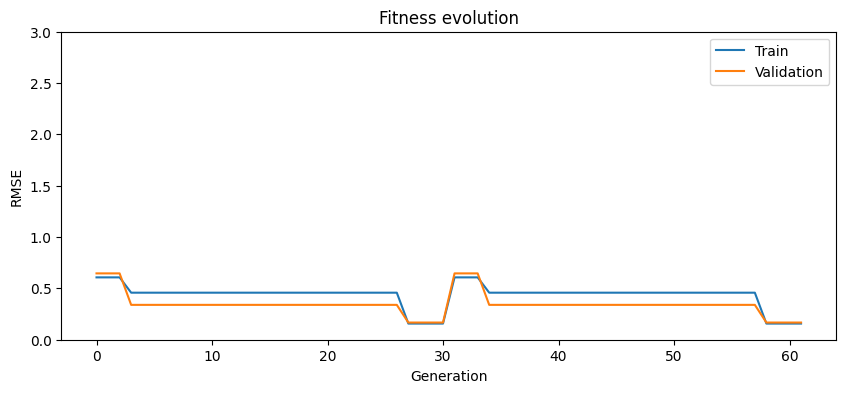

AttributeError: 'NoneType' object has no attribute 'item'

In [17]:
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_test_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=3)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} test.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


In [ ]:
# plt.figure(figsize=(10, 4))

# plt.plot(history_sizes)
# plt.title('Solution size evolution')
# plt.xlabel('Generation')
# plt.ylabel('Size')
# plt.ylim(bottom=0)
# plt.show()


In [ ]:
# plt.figure(figsize=(10, 4))

# plt.plot(history_timing)
# plt.title('Running time evolution')
# plt.xlabel('Generation')
# plt.ylabel('Seconds')
# plt.ylim(bottom=0, top=120)
# plt.show()

# print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))
